# COVID-19 NYT Data Set

In this file, we will load the NYT COVID-19 data set available in CAS as well as census data set containing estimates for the US population in 2019. We will combine information from both data sets to figure out the number of cases and deaths per 1,000,000 residents of each state on each day for which we have data. Afterwards, we will use both regular line plots as well as a choropleth map to visualize the data.

## Data Setup

In [1]:
import swat   # connect to CAS data sets
import os     # needed to get some environment variables
              # for the connection

# this code establishes a connection with CAS
conn = swat.CAS(os.environ.get("CASHOST"), 
                os.environ.get("CASPORT"),
                None,os.environ.get("SAS_VIYA_TOKEN"))

# loads the NYT coronavirus data set from the CAS library 
nyt_table = conn.CASTable(caslib = "COVID19", name = "NYT_CORONA_VIRUS")

# export from SAS-type data set ('table') to Pandas DataFrame
nyt_df = nyt_table.to_frame()

In [2]:
# this is for type-hinting in function definitions:
from typing import List, Dict  

# some standard imports from Python for this 
# type of work
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# some nice imports to make life easier
# 1) make matplotlib aware of Pandas DateTime format
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# 2) create nicer date formatting in plots
import matplotlib.dates as mdates

Since the source data set lists data from various counties separately, we first simplify our work by adding up all the cases in each state so that we have only one row of data per state per date for which we have data. We'll write a small function to do this task for us.

In [3]:
def make_state_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to process the initial data in two ways:
    1) Filter down the columns to the important ones, dropping
       columns that we don't need for our analysis. 
    2) Each state is broken down into counties in the NYT data set,
       but we want state level information. We sum across the counties
       in the state.
    Overall, this function is comparable to a "data step" and "proc freq"
    in SAS.
    """
    
    # filter out unnecessary information. Think of a SAS 'keep' statement.
    df = df.filter(['Date', 'State','Cases','Deaths', 'STATECODE', 
                    'State_Latitude', 'State_Longitude'])
    
    # sums up the data by 'Date', 'State, 'Statecode',
    # 'State_Latitude', 'State_Longitude' information
    # - this returns state-level 'cases' and 'deaths'
    short = df.groupby(['Date', 'State', 'STATECODE', 
                    'State_Latitude', 'State_Longitude'],
                        as_index=False).sum()
    return short

# call our function to apply the manipulation from the 
# `make_state_summary` function.
df = make_state_summary(nyt_df)

Let's verify the data types to make sure we have everything we need:

In [4]:
df.dtypes

Date                object
State               object
STATECODE           object
State_Latitude     float64
State_Longitude    float64
Cases              float64
Deaths             float64
dtype: object

Note that the date is listed as an "object" type, i.e. a type of string. In order to handle the dates as datas, we need to convert this columns to a datetime object first.

In [5]:
df.Date = pd.to_datetime(df.Date) # assign datetime obj to Date column,
                                  # overwriting the old column (and type)
df.dtypes  # just here to print the type so we can verify

Date               datetime64[ns]
State                      object
STATECODE                  object
State_Latitude            float64
State_Longitude           float64
Cases                     float64
Deaths                    float64
dtype: object

Since we ultimately want to figure out the case-load and death-toll per million residents of each state, we use a data set from the census bureau which includes estimates for 2019. This data set is already saved on Viya for Learners, so we merely need to read it in. Note that we use the `filter` method (similar to a `keep` in SAS) to only load columns we are interested in.

In [6]:
pop_set = pd.read_csv("/shared/courses/ACADEMIC/nst-est2019-alldata.csv").filter(['REGION', 'DIVISION', 'STATE', 'NAME', 'CENSUS2010POP',
                          'ESTIMATESBASE2010', 'POPESTIMATE2019'])

## Updating our Data Set with the Census Information

Now that we have both data sets in memory, we will calculate the case-load and death-toll for each state and date, with the calculated values added to our data set.

In [7]:
def update_case_load(source : pd.DataFrame, 
                    census : pd.DataFrame) -> pd.DataFrame:
    """
    Function to update a dataframe to include case-load
    and death-toll per million residents using a census
    data set as look-up table for population values.
    """
    
    # for loop iterates over all rows in the 'source' dataframe
    for index, row in source.iterrows():
        state = row["State"]  # looks-up current statename of row
        # looks-up the "POPESTIMATE2019" column value associated with 
        # that state in the `census` dataframe. 
        pop = census[census.NAME==state]["POPESTIMATE2019"].to_numpy()[0]
        
        # use the pop value to calculate cases/deaths per million residents
        cases_per_million = 1e6*row["Cases"]/pop
        deaths_per_million = 1e6*row["Deaths"]/pop
        
        # update `source` dataframe with three new column values
        source.loc[index,"Population"] = pop
        source.loc[index,"CPM"] = cases_per_million
        source.loc[index, "DPM"] = deaths_per_million
    return source

# run the functon to actually apply the calculations
# defined in the `update_case_load` function.
df = update_case_load(df, pop_set)

At this stage, we have two Pandas dataframes in memory - the `pop_set` dataframe which was used a look-up table for state population information, and the main dataframe `df` which contains the following columns of information we want for our visualizations:

In [8]:
df.dtypes

Date               datetime64[ns]
State                      object
STATECODE                  object
State_Latitude            float64
State_Longitude           float64
Cases                     float64
Deaths                    float64
Population                float64
CPM                       float64
DPM                       float64
dtype: object

## Simple Plot Visualition

Let's start with a few simple visualizations to compare different states. To make it easier, we create a short function that gets the necessary data out, followed by a short function to do the plotting with the output data set.

In [9]:
def state_sets(df : pd.DataFrame, States: List) -> Dict:
    """
    This function is similar to a data step in SAS. It takes
    in a list of state-codes of interest together with the main
    dataframe and returns a dictionary where each statecode is mapped
    to a dataframe containing only the information from that state.
    """
    # use a quick dictionary comprehension to subset the data
    out_dict = {state : df[df.STATECODE==state] for state in States }
    return out_dict

def line_plot_states(states_of_interest : Dict,
                    min_date : str = "2020-03-01"):
    """
    Convenience function to do the plotting.
    Takes a dictionary of states and a start date and then 
    makes a line plot of the 'cases per million' variable in
    all states listed in the dictionary.
    """
    # define plot size
    fig, ax = plt.subplots(figsize=(10,5.625))
    
    # iterates over the dictionary and adds each state's 
    # line to the plot
    for key, data in states_of_interest.items():
        subdata = data[data.Date>=pd.to_datetime(min_date)]
        ax.plot(subdata.Date, subdata.CPM, label=key)
    ax.legend() # turns on the legend

    # make the axes pretty
    fig.autofmt_xdate()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_ylabel('Cases per Million')

    plt.show(fig) # necessary to display the plot

 Now all we need to do is call our function and then iterate through the result to plot several different states. Feel free to experiment with a different set of states than the ones listed here.

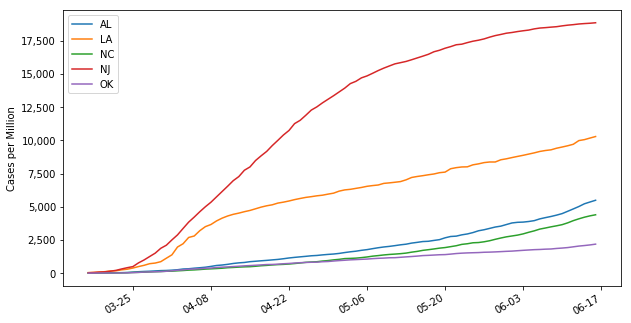

In [10]:
# list of states, sort it so that the legend is alphabetical
state_list = sorted(["LA", "AL", "NC", "NJ", "OK"])

# get the dictionary of state data out
states_of_interest = state_sets(df, state_list)

# does the plotting
line_plot_states(states_of_interest, "2020-03-17")

## Making a Heat Map

It can be hard to keep track of all states and all dates with a line chart. Let's try using a heat map instead. We'll bring our pandas Dataframe back to SAS using the SASPy package. We'll begin by importing the SASPy package and establishing a connection to SAS.

In [11]:
import saspy  # package to get access to SAS

# this command starts the SAS connection
# and makes it available as an object called
# `sas_session`
sas_session = saspy.SASsession()

Using SAS Config named: iomlinux
SAS Connection established. Subprocess id is 41856



With the connection established, we will use the `df2sd` method on our SAS session object to move our dataframe from Python over to our SAS working library.

In [12]:
# syntax: connection_obj.df2sd(dataframe_var, table="name_of_table_in_SAS")
sas_session.df2sd(df, table="full_data")

Libref  = WORK
Table   = full_data
Dsopts  = {}
Results = Pandas

With the table available in our working library, we will use the `%%SAS` magic keyword to run the necessary SAS code to generate our heatmap. Notice that every line after the magic keyword is pure SAS code.


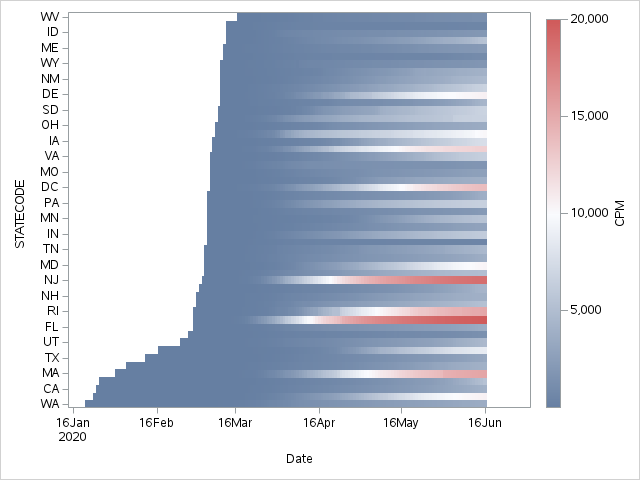

In [13]:
%%SAS sas_session

proc sgplot data=work.full_data;
    format CPM COMMA12.;
	heatmapparam x=Date y=STATECODE colorresponse=CPM / name='HeatMap'  ;
	gradlegend 'HeatMap';
run;

Note that the states on the y-axis are sorted by the amount of data we have, with us having the most data points for states like Washington and California, and the fewest for states like West Virgina and Idaho. For comparison, we can make the same plot with the raw case data.


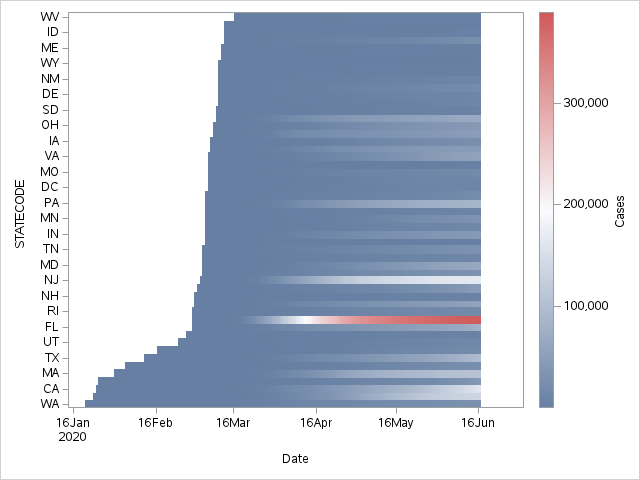

In [14]:
%%SAS sas_session

proc sgplot data=work.full_data;
    format Cases COMMA10.;
    heatmapparam x=Date y=STATECODE colorresponse=Cases / name='HeatMap' discretey ;
    gradlegend 'HeatMap';
run;

Note that if we focus on raw counts alone, many states appear to be doing better than they actually are.

## Making the Map

Making maps and plotting over them is hard. Luckily, SAS has a few special procedures for this available. To make our work easier, we will first collect the necessary information we want from our Python data set and then export it to SAS for plotting. We'll pick data corresponding to a single date, say May 20, and upload the data set to SAS. Feel free to choose a different date than we have here.

In [15]:
# list of dates of interest
# note that the SAS code below expects only one date,
# so if you choose to make a list of multiple dates here,
# please also update the SAS code below to pick a specific
# date for plotting.
# Use format 'YYYY-MM-DD' for the dates
dates_of_interest = ["2020-06-16"]

# uses the above list to subset the dataframe
sub_df = df[df.Date.isin(dates_of_interest)]

# uploads the dataframe to SAS under the name
# work.map_data
sas_session.df2sd(sub_df, table="map_data")

Libref  = WORK
Table   = map_data
Dsopts  = {}
Results = Pandas

The `proc sgmamp` procedure in base SAS can help us make the type of graphic we are looking for. [See here](https://blogs.sas.com/content/graphicallyspeaking/2017/12/14/sgmap-now-in-base-sas/) for a nice blog post about it and [here the documentation](https://go.documentation.sas.com/?docsetId=grmapref&docsetTarget=n12i6frnyv35f6n16p7bo3u6hy2a.htm&docsetVersion=9.4_01&locale=en) of this function. We'll now make a bubble plot that gives us a feeling for how the data is distributed. Note that we're excluding Alaska and Hawaii to plot only the continental US. This produces a more readable plot.


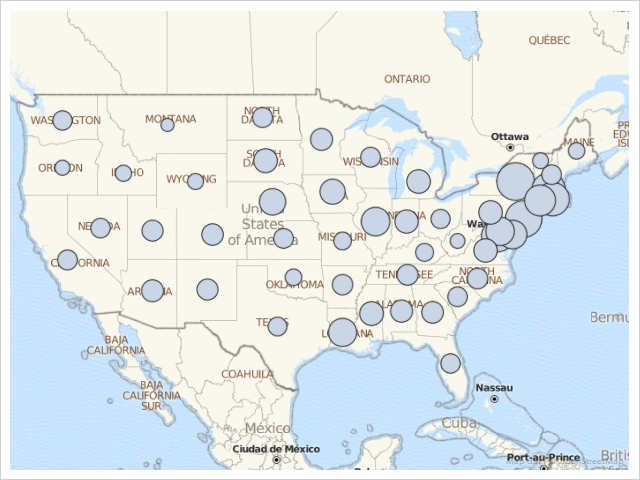

In [16]:
%%SAS sas_session

proc sgmap plotdata=work.map_data;
     openstreetmap;
    where STATECODE not in ('AK','HI');
     bubble x=State_Longitude y=State_Latitude size=CPM;
run;

It would be nice if we could get a choropleth map of the situation. This would allow us to use a color scheme to differentiate between different classes of states, based on the CPM value. Well, `gmap` to the rescue. We will use the `levels=5` statement to use quintile binning. Note how few lines of code are needed to create a very high quality visualization in SAS.

In [17]:
%%SAS sas_session

proc gmap data=work.map_data map=mapsgfk.us all;
    id STATECODE;
    format CPM COMMA10.;
    choro CPM / levels=5;
run;

Notice that the ranges aren't close to being the same size. We can use the `midpoints` statement to force a different selection of levels. For example, by using `midpoints=old`, we can use the Nelder algorithm to determine the appropriate ranges and midpoints. This produces a more nuanced graph of the situation.

In [18]:
%%SAS sas_session

proc gmap data=work.map_data map=mapsgfk.us all;
    id STATECODE;
    format CPM COMMA10.;
    choro CPM / midpoints=old;
run;

This highlights the very uneven distribution of COVID-19 cases per resident across the United States, a fact that can be difficult to visualize in other ways.

For even more refinement, we can also ask SAS to produce a heatmap in the shape of the US and plot our case load over that. This does require more code than the previous examples, however. 


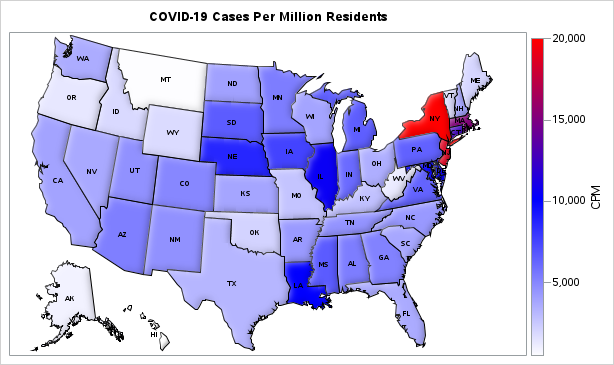

In [19]:
%%SAS sas_session


/* get map data of the US sorted by statecode */
proc sort data=mapsgfk.us out=USBorders equals;
	by statecode;
run;

/* ensure that our CPM data is sorted by statecode */ 
proc sort data=work.map_data out=map_sort(keep=statecode cpm) equals;
    by statecode;
run;

/* merge the two data sets so that we can plot the information in them */
data USHeatMap;
	merge USBorders map_sort;
	by statecode;

	if statecode ne 'DC';
run;

%annomac; /* Make the SAS/GRAPH annotate macros available */
%centroid(mapsgfk.us, centers, id);

/* Polygon center is used to place each label */
data map(drop=statecode segment);
	set USHeatMap centers(rename=(x=xCen y=yCen) in=a);

	if a then
		Label=fipstate(input(substr(id, 4, 2), 2.));

	/* State postal code */
	id=catx('-', id, segment);

	/* Combine ID and Segment to make unique ID */
	if label='ID' then
		ycen + -.025;

	/* Adjust a few label coordinates */
	if label='MI' then
		ycen + -.025;

	if label='HI' then
		ycen + -.01;

	if label='NH' then
		ycen + -.012;

	if label='VT' then
		ycen + .01;

	if label='MD' then
		ycen + .007;

	if label='AK' then
		ycen + .01;

	if label='DE' then
		do;
			ycen + -.005;
			xcen + .005;
		end;

	if label='DC' then
		delete;
run;

ods graphics on / height=3.8in width=6.4in;

proc sgplot data=map noautolegend;
format CPM COMMA12.;
	title 'COVID-19 Cases Per Million Residents';
	polygon x=x y=y id=id / outline lineattrs=(color=black) 
		colorresponse=cpm colormodel=(white blue red)
 dataSkin=matte fill name='map';
	scatter x=xcen y=ycen / markerchar=label markercharattrs=(size=5);
	gradlegend 'map';
	label density_2010='People per Square Mile';
	xaxis offsetmin=0.01 offsetmax=0.01 display=none;
	yaxis offsetmin=0.01 offsetmax=0.01 display=none;
run;

ods graphics on / reset=all;

## Export Data

In case we want to work with these data sets later in SAS, we can export what we have both to CSV files and to SAS datasets that are saved in VFL and will be accessible from the SAS Studio side. This is entirely optional.

In [20]:
#the csv save

df.to_csv("full_data.csv")
sub_df.to_csv("map_data.csv")

In [21]:
%%SAS sas_session

OPTIONS DLCREATEDIR;
LIBNAME c19 "/shared/home/&SYSUSERID/mycovid/";

data c19.full_data;
    set work.full_data;
run;

data c19.map_data;
    set work.map_data;
run;

Now you can go explore the data outside of this notebook as well!